In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

%matplotlib inline
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

import xgboost as xgb
from nltk.corpus import stopwords

In [2]:
def rmse(x,y):
    return np.mean((x - y) ** 2) ** 0.5

#### Посмотрим на тайтлы

In [3]:
titles_train = pd.read_csv("data/title_unify_train", sep="\t", header=None, encoding='utf-8')
titles_train.columns = ["Id", "title", "count"]
titles_train1 = pd.DataFrame(titles_train.groupby("Id")['title'].apply(lambda x: x.tolist()))
titles_train1.title = titles_train1.title.apply(lambda x: " ".join(x)) ## склеили тайтлы по юзеру вместе

In [4]:
titles_train1 = titles_train1.reset_index()
titles_train1.head()

,Id,title
0,000000013CB5719C0000A2C90002C101,бесплатный надёжный почта рамблер электронный ...
1,00000001442BE24000001B7D00F50801,24-х 34-х до договор неделя новость предложить...
2,00000001448580F800003F1B31FB0901,авто бош контакт королёв сервис авто бош корол...
3,0000000145BDB2FF000157971645E901,ua втрать війни донбасі за на новини озвучить ...
4,000000014602771F0000DB9359714C01,black walnut грецкий орех чёрный inmoment ru w...


загрузим трейн по возрасту

In [5]:
age_train_df = pd.read_csv('data/age_profile_train', header=None, delimiter='\t')
age_train_df.columns = ['Id', 'age']

####  Добавим урлы

In [84]:
urls_train_df = pd.read_csv('data/url_domain_train', header=None, delimiter='\t')
urls_train_df.columns = ['Id', 'url', 'Count']

In [85]:
url_df = urls_train_df.drop("Count", axis=1).merge(age_train_df, on='Id', how='left')
url_df = url_df.sort_values(by="Id")
url_df["decade"] = url_df.age.apply(lambda x: int(np.floor((x)/10)))

В предположении, что p(url|age) имеет некоторое распределение, восстановим распределение урлов про декадам на обучающей выборке 

In [86]:
aggreg = url_df.groupby(["url", "decade"]).age.count().unstack()
aggreg = aggreg.fillna(0)
aggreg = aggreg.reset_index()
aggreg["all_cnt"] = aggreg[aggreg.columns[1:]].sum(axis=1)

In [115]:
aggreg_filt = aggreg#[aggreg.all_cnt > 2]

In [116]:
aggreg_urls_probs_filt = pd.concat([aggreg_filt.url, aggreg_filt[aggreg_filt.columns[1:-1]].div(aggreg_filt.all_cnt, axis='rows')], axis=1)

In [117]:
aggreg_urls_probs_filt.head()

,url,0,1,2,3,4,5,6,7,8,9
0,0-1.a100.nthosting.ru,0.333333,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0-1.ru,0.028409,0.011364,0.210227,0.346591,0.215909,0.136364,0.045455,0.005682,0.0,0.0
2,0-15kdm.ru,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,0-3.ru,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0
4,0-360.ru,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.0,0.0


In [118]:
all_set_probs = urls_train_df.drop("Count", axis=1).merge(aggreg_urls_probs_filt, on="url").sort_values(by="Id").reset_index().drop("index", axis=1)

In [119]:
all_set_probs.head()

,Id,url,0,1,2,3,4,5,6,7,8,9
0,000000013CB5719C0000A2C90002C101,r0.ru,0.011605,0.034816,0.150870,0.311412,0.206963,0.189555,0.075435,0.013540,0.005803,0.000000
1,000000013CB5719C0000A2C90002C101,id.rambler.ru,0.014819,0.060953,0.305132,0.305351,0.182714,0.089350,0.032776,0.006351,0.001533,0.001022
2,000000013CB5719C0000A2C90002C101,mail.rambler.ru,0.019425,0.036012,0.243083,0.313185,0.216987,0.119580,0.041846,0.007576,0.001357,0.000950
3,00000001442BE24000001B7D00F50801,secretmag.ru,0.019522,0.013147,0.139442,0.285259,0.283665,0.173705,0.067331,0.014343,0.001992,0.001594
4,00000001442BE24000001B7D00F50801,govoritmoskva.ru,0.018112,0.020972,0.197331,0.249762,0.220210,0.179218,0.088656,0.017159,0.006673,0.001907


In [120]:
aggr = pd.concat([all_set_probs.groupby("Id").sum(), all_set_probs.groupby("Id").count()[0]], axis=1)

In [121]:
aggr.head(2)

,0,1,2,3,4,5,6,7,8,9,0
Id,,,,,,,,,,,
000000013CB5719C0000A2C90002C101,0.045849,0.131781,0.699085,0.929948,0.606665,0.398485,0.150057,0.027466,0.008692,0.001972,3
00000001442BE24000001B7D00F50801,0.819073,0.686682,6.875526,10.354937,9.113721,6.139414,2.482999,0.390805,0.073883,0.062959,37


In [122]:
aggr.columns = ["decade_0", "decade_1", "decade_2", "decade_3", "decade_4",
               "decade_5", "decade_6", "decade_7", "decade_8", "decade_9", "cnt"] 

In [123]:
aggr.head()

,decade_0,decade_1,decade_2,decade_3,decade_4,decade_5,decade_6,decade_7,decade_8,decade_9,cnt
Id,,,,,,,,,,,
000000013CB5719C0000A2C90002C101,0.045849,0.131781,0.699085,0.929948,0.606665,0.398485,0.150057,0.027466,0.008692,0.001972,3
00000001442BE24000001B7D00F50801,0.819073,0.686682,6.875526,10.354937,9.113721,6.139414,2.482999,0.390805,0.073883,0.062959,37
00000001448580F800003F1B31FB0901,0.000000,0.333333,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
0000000145BDB2FF000157971645E901,0.145078,0.334114,2.590656,3.329806,1.974950,1.154019,0.397011,0.064615,0.003316,0.006435,10
000000014602771F0000DB9359714C01,0.113171,0.435530,3.085147,3.202767,2.284845,1.519141,0.294689,0.059143,0.004823,0.000743,11


In [124]:
probs_users = aggr[aggr.columns[:-1]].div(aggr[aggr.columns[-1]], axis="rows")

In [137]:
decades = [i*10+5 for i in range(10)]  # по центрам интервалов
decades

[5, 15, 25, 35, 45, 55, 65, 75, 85, 95]

взвесим согласно вероятностям

In [138]:
pred_simple_probs_urls = probs_users.apply(lambda x: sum(x.values*decades), axis=1)

In [139]:
m = pred_simple_probs_urls.reset_index().merge(age_train_df)
m.columns = ["Id", "prob", "age"]
m.head(2)

,Id,prob,age
0,000000013CB5719C0000A2C90002C101,38.062559,53
1,00000001442BE24000001B7D00F50801,40.525900,48


In [141]:
rmse(m.prob.values, m.age.values)  ## даже такой простой подход дает неплохой результат! неплохоо

11.646980267145002

попробуем другое дробление возраста - не на декады, а по равновероятным cumsum интервалам

In [129]:
# 10 штук
interval_labels = [22, 26, 29, 31, 34, 38, 41, 46, 53]  # побъем cussum по равновероятным интервалам

# 20 штук

interval_labels20  = []

In [131]:
def create_intervals(age):
    if age < 22:
        return 0
    if age >= 22 and age <= 26:
        return 1
    if age > 26 and age <= 29:
        return 2
    if age > 29 and age <= 31:
        return 3
    if age > 31 and age <= 34:
        return 4
    if age > 34 and age <= 38:
        return 5
    if age > 38 and age <= 41:
        return 6
    if age > 41 and age <= 46:
        return 7
    if age > 46 and age <= 53:
        return 8
    if age > 53:
        return 9

теперь повторим то же самое

In [499]:
url_df = urls_train_df.drop("Count", axis=1).merge(age_train_df, on='Id', how='left')
url_df = url_df.sort_values(by="Id")
url_df["decade"] = url_df.age.apply(create_intervals)

In [500]:
aggreg = url_df.groupby(["url", "decade"]).age.count().unstack()
aggreg = aggreg.fillna(0)
aggreg = aggreg.reset_index()
aggreg["all_cnt"] = aggreg[aggreg.columns[1:]].sum(axis=1)

aggreg_filt = aggreg#[aggreg.all_cnt > 2]
aggreg_urls_probs_filt = pd.concat([aggreg_filt.url, aggreg_filt[aggreg_filt.columns[1:-1]].div(aggreg_filt.all_cnt, axis='rows')], axis=1)

all_set_probs = urls_train_df.drop("Count", axis=1).merge(aggreg_urls_probs_filt, on="url").sort_values(by="Id").reset_index().drop("index", axis=1)

aggr = pd.concat([all_set_probs.groupby("Id").sum(), all_set_probs.groupby("Id").count()[0]], axis=1)
aggr.columns = ["decade_0", "decade_1", "decade_2", "decade_3", "decade_4",
               "decade_5", "decade_6", "decade_7", "decade_8", "decade_9", "cnt"] 
probs_users = aggr[aggr.columns[:-1]].div(aggr[aggr.columns[-1]], axis="rows")

In [501]:
probs_users.head(2)

,decade_0,decade_1,decade_2,decade_3,decade_4,decade_5,decade_6,decade_7,decade_8,decade_9
Id,,,,,,,,,,
000000013CB5719C0000A2C90002C101,0.090940,0.091018,0.110280,0.071454,0.106768,0.095862,0.098688,0.090686,0.124294,0.120008
00000001442BE24000001B7D00F50801,0.059752,0.064204,0.102565,0.059760,0.089081,0.084155,0.106211,0.101531,0.176652,0.156089


In [502]:
## intervals = [22, 26, 29, 31, 34, 38, 41, 46, 53]
#decades = [11, 24, 27, 30, 33, 36, 39, 43, 50, 76]  # по центрам интервалов

decades = [0, 15, 22, 28, 30, 36, 40, 45, 55, 77]  # не по центрам интервалов

взвесим согласно вероятностям

In [503]:
pred_simple_probs_urls = probs_users.apply(lambda x: sum(x.values*decades), axis=1)

In [504]:
m = pred_simple_probs_urls.reset_index().merge(age_train_df)
m.columns = ["Id", "prob", "age"]
m.head(2)

,Id,prob,age
0,000000013CB5719C0000A2C90002C101,36.551444,53
1,00000001442BE24000001B7D00F50801,41.146850,48


In [505]:
rmse(m.prob.values, m.age.values)  ## еще лучше!!!!

11.204294219306224

#### Впендюрим для теста

In [506]:
urls_test_df = pd.read_csv('data/url_domain_test', header=None, delimiter='\t')
urls_test_df.columns = ['Id', 'url', 'Count']

In [507]:
aggreg_urls_probs_filt.head()

,url,0,1,2,3,4,5,6,7,8,9
0,0-1.a100.nthosting.ru,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0-1.ru,0.051136,0.062500,0.136364,0.113636,0.090909,0.102273,0.090909,0.090909,0.147727,0.113636
2,0-15kdm.ru,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0-3.ru,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
4,0-360.ru,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000


In [508]:
all_set_probs_test = urls_test_df.drop("Count", axis=1).merge(aggreg_urls_probs_filt).sort_values(by="Id").reset_index().drop("index", axis=1)

In [509]:
all_set_probs_test.head()

,Id,url,0,1,2,3,4,5,6,7,8,9
0,000000014A02348E701552980349FF01,finance.rambler.ru,0.042289,0.043373,0.062651,0.052048,0.089880,0.092651,0.102530,0.129277,0.185663,0.199639
1,000000014A02348E701552980349FF01,stringer-news.com,0.054348,0.108696,0.065217,0.065217,0.076087,0.086957,0.097826,0.054348,0.130435,0.260870
2,000000014A02348E701552980349FF01,1tv.ru,0.088350,0.117178,0.132779,0.086145,0.107173,0.080041,0.083602,0.093946,0.109886,0.100899
3,000000014A02348E701552980349FF01,potsreotizm.livejournal.com,0.055556,0.111111,0.111111,0.000000,0.111111,0.166667,0.055556,0.166667,0.111111,0.111111
4,000000014A02348E701552980349FF01,spb.kp.ru,0.068063,0.078534,0.097731,0.068063,0.082024,0.085515,0.082024,0.102967,0.160558,0.174520


In [510]:
aggr_test = pd.concat([all_set_probs_test.groupby("Id").sum(), all_set_probs_test.groupby("Id").count()[0]], axis=1)
aggr_test.columns = ["decade_0", "decade_1", "decade_2", "decade_3", "decade_4",
               "decade_5", "decade_6", "decade_7", "decade_8", "decade_9", "cnt"] 
probs_users_test = aggr_test[aggr_test.columns[:-1]].div(aggr_test[aggr_test.columns[-1]], axis="rows")

In [511]:
probs_users_test.head(2)

,decade_0,decade_1,decade_2,decade_3,decade_4,decade_5,decade_6,decade_7,decade_8,decade_9
Id,,,,,,,,,,
000000014A02348E701552980349FF01,0.079265,0.087682,0.100754,0.063741,0.104640,0.088078,0.088226,0.110199,0.139706,0.137709
000000014A10EA183BF8594A0B2AB201,0.066700,0.074079,0.090038,0.067339,0.093445,0.092733,0.096282,0.116003,0.150577,0.152805


предскажем

In [512]:
#decades = [11, 24, 27, 30, 33, 36, 39, 43, 50, 76]  # по центрам интервалов
decades = [0, 15, 22, 28, 30, 36, 40, 45, 55, 77] # не по центрам интервалов
pred_simple_probs_test = probs_users_test.apply(lambda x: sum(x.values*decades), axis=1)

In [513]:
pred_simple_probs_test.head(2)


Id
000000014A02348E701552980349FF01    38.402019
000000014A10EA183BF8594A0B2AB201    40.238338
dtype: float64

In [514]:
pred_simple_probs_test.shape

(19974,)

In [515]:
sample_df = pd.read_csv('sample_submission.csv')
sample_df.shape

(19979, 2)

In [516]:
miss_idx = set(sample_df.Id.values) - set(pred_simple_probs_test.index.values)
miss_idx  ## есть 

{'00000001545483F30F717F5A0721E401',
 '00000046549F9C26429C4B0159BFEE01',
 '000000465684D839B64B58DA9701F701',
 '000022D456544DE3771122F857A6F201',
 '06210D9556EFE0E30000054678B0D901'}

In [517]:
miss_df = pd.DataFrame(zip(list(miss_idx), 30* np.ones(len(miss_idx))))
miss_df.columns = ['Id', 'age']
#miss_df = miss_df.set_index("Id")
miss_df

,Id,age
0,000022D456544DE3771122F857A6F201,30.0
1,06210D9556EFE0E30000054678B0D901,30.0
2,00000046549F9C26429C4B0159BFEE01,30.0
3,00000001545483F30F717F5A0721E401,30.0
4,000000465684D839B64B58DA9701F701,30.0


In [518]:
pred_simple_probs_test = pred_simple_probs_test.reset_index()
pred_simple_probs_test.columns = ["Id", "age"]

In [519]:
pred_simple_probs_test.head()

,Id,age
0,000000014A02348E701552980349FF01,38.402019
1,000000014A10EA183BF8594A0B2AB201,40.238338
2,000000014A4FE5C33A929D4C26943601,40.370623
3,000000014B7BB9957784A9BC0AC9F401,37.245949
4,000000014C7749F896D82C2B01E8B801,36.052225


In [520]:
all_test_set = pd.merge(pred_simple_probs_test.reset_index(), miss_df, on=["Id", "age"], how="outer").drop("index", axis=1)

In [521]:
all_test_set = all_test_set.sort_values(by="Id")
all_test_set.head()

,Id,age
0,000000014A02348E701552980349FF01,38.402019
1,000000014A10EA183BF8594A0B2AB201,40.238338
2,000000014A4FE5C33A929D4C26943601,40.370623
3,000000014B7BB9957784A9BC0AC9F401,37.245949
4,000000014C7749F896D82C2B01E8B801,36.052225


In [522]:
all_test_set.shape

(19979, 2)

In [523]:
all_test_set.to_csv("simple_prob_urls_another_decades.csv", index=False)

In [540]:
eee = pd.DataFrame(pd.concat([all_test_set.Id, all_test_set.age.apply(lambda x: np.floor(x))], axis=1))
eee.columns = ["Id","age"]

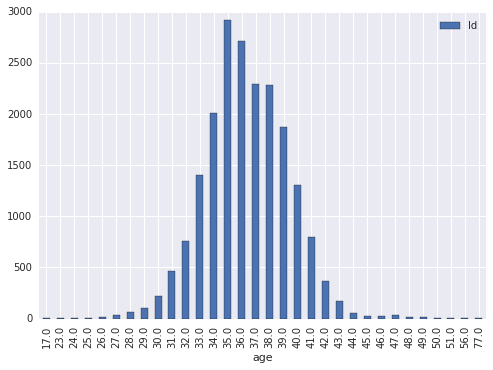

In [553]:
eee.groupby("age").count().reset_index().sort_values(by="age").set_index("age").plot(kind="bar")

In [547]:
eee.age.unique()

array([ 38.,  40.,  37.,  36.,  39.,  43.,  34.,  33.,  41.,  42.,  32.,
        35.,  28.,  44.,  31.,  30.,  45.,  29.,  46.,  48.,  50.,  77.,
        49.,  51.,  27.,  23.,  47.,  26.,  25.,  17.,  24.,  56.])

In [175]:
all_set = urls_train_df.drop("Count", axis=1).merge(aggreg, how="outer")

In [176]:
all_set = all_set.groupby("Id").sum()

In [177]:
allset = all_set.reset_index().merge(age_train_df, how="outer")

In [178]:
allset = allset.fillna(0)

In [179]:
allset.head()

,Id,0,1,2,3,4,5,6,7,8,9,all_cnt,age
0,000000013CB5719C0000A2C90002C101,1927.0,4038.0,25757.0,32043.0,21801.0,11898.0,4189.0,764.0,144.0,98.0,102659.0,53
1,00000001442BE24000001B7D00F50801,3786.0,3830.0,30596.0,57843.0,51875.0,35438.0,14918.0,2716.0,490.0,283.0,201775.0,48
2,00000001448580F800003F1B31FB0901,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,28
3,0000000145BDB2FF000157971645E901,155.0,273.0,2258.0,2976.0,2066.0,1246.0,442.0,64.0,6.0,7.0,9493.0,44
4,000000014602771F0000DB9359714C01,65.0,156.0,1247.0,1351.0,804.0,449.0,113.0,28.0,5.0,1.0,4219.0,48


In [184]:
normed_probs = pd.concat([allset[allset.columns[:1]], allset[allset.columns[1:-2]].div(allset.all_cnt, axis='rows'),], axis=1)

In [185]:
normed_probs.head()

,Id,0,1,2,3,4,5,6,7,8,9
0,000000013CB5719C0000A2C90002C101,0.018771,0.039334,0.250899,0.312130,0.212363,0.115898,0.040805,0.007442,0.001403,0.000955
1,00000001442BE24000001B7D00F50801,0.018763,0.018982,0.151634,0.286671,0.257093,0.175631,0.073934,0.013461,0.002428,0.001403
2,00000001448580F800003F1B31FB0901,0.000000,0.333333,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0000000145BDB2FF000157971645E901,0.016328,0.028758,0.237859,0.313494,0.217634,0.131255,0.046561,0.006742,0.000632,0.000737
4,000000014602771F0000DB9359714C01,0.015406,0.036976,0.295568,0.320218,0.190566,0.106423,0.026784,0.006637,0.001185,0.000237


In [187]:
normed_probs.shape

(118679, 11)

In [188]:
normed_probs = normed_probs.fillna(0.0)

In [189]:
normed_probs = normed_probs.sort_values(by="Id")

In [190]:
## учтем и каунты тоже
urls_train_df.url = urls_train_df.url.apply(lambda x: ".".join(x.split(".")[:-1]))
urls_train_df.url = urls_train_df.url.apply(lambda x: x+" ")
urls_train_df.url = urls_train_df.url.multiply(urls_train_df.Count)
urls_train_df.url = urls_train_df.url.apply(lambda x: x.strip())
urls_train_df.url = urls_train_df.url.apply(lambda x: ' '.join(x.split(' ')))

In [191]:
urls_train_df = pd.DataFrame(urls_train_df.groupby('Id')['url'].apply(lambda x: x.tolist()))
urls_train_df['Id'] = urls_train_df.index
urls_train_df.index = range(len(urls_train_df))
urls_train_df.columns = ['urls', 'Id']

In [192]:
urls_train_df.urls = urls_train_df.urls.apply(lambda x: ' '.join(x))

In [193]:
urls_train_df.head()

,urls,Id
0,id.rambler mail.rambler r0,000000013CB5719C0000A2C90002C101
1,1prime autorambler chellak docs.cntd docs.cntd...,00000001442BE24000001B7D00F50801
2,bosch-korolev,00000001448580F800003F1B31FB0901
3,aptekanizkihcen colady gorod.dp i.ovkuse love....,0000000145BDB2FF000157971645E901
4,astrorok diets edaplus eshzdorovo gotovim inmo...,000000014602771F0000DB9359714C01


#### загрузим данные по возрасту

In [10]:
age_train_df = pd.read_csv('data/age_profile_train', header=None, delimiter='\t')
age_train_df.columns = ['Id', 'age']

In [194]:
train_df_title = titles_train1.merge(age_train_df, on='Id', how='outer')
#train_df_urls = urls_train_df.merge(age_train_df, on='Id', how='left')

train_df = train_df_title.merge(urls_train_df, on='Id', how='outer')
train_df = train_df.merge(normed_probs, how="left")

In [195]:
train_df.shape

(118679, 14)

In [199]:
train_df[pd.isnull(train_df.urls)].head()

,Id,title,age,urls,0,1,2,3,4,5,6,7,8,9


In [197]:
train_df.urls.fillna('', inplace=True)

In [201]:
train_df[pd.isnull(train_df.title)].head()

,Id,title,age,urls,0,1,2,3,4,5,6,7,8,9


In [200]:
train_df.title.fillna('', inplace=True)

In [203]:
train_df.head()

,Id,title,age,urls,0,1,2,3,4,5,6,7,8,9
0,000000013CB5719C0000A2C90002C101,бесплатный надёжный почта рамблер электронный ...,53,id.rambler mail.rambler r0,0.018771,0.039334,0.250899,0.312130,0.212363,0.115898,0.040805,0.007442,0.001403,0.000955
1,00000001442BE24000001B7D00F50801,24-х 34-х до договор неделя новость предложить...,48,1prime autorambler chellak docs.cntd docs.cntd...,0.018763,0.018982,0.151634,0.286671,0.257093,0.175631,0.073934,0.013461,0.002428,0.001403
2,00000001448580F800003F1B31FB0901,авто бош контакт королёв сервис авто бош корол...,28,bosch-korolev,0.000000,0.333333,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0000000145BDB2FF000157971645E901,ua втрать війни донбасі за на новини озвучить ...,44,aptekanizkihcen colady gorod.dp i.ovkuse love....,0.016328,0.028758,0.237859,0.313494,0.217634,0.131255,0.046561,0.006742,0.000632,0.000737
4,000000014602771F0000DB9359714C01,black walnut грецкий орех чёрный inmoment ru w...,48,astrorok diets edaplus eshzdorovo gotovim inmo...,0.015406,0.036976,0.295568,0.320218,0.190566,0.106423,0.026784,0.006637,0.001185,0.000237


проделаем то же с тестовым сетом

In [202]:
titles_test = pd.read_csv("data/title_unify_test", sep="\t", header=None,encoding='utf-8')
titles_test.columns = ["Id", "title", "count"]
titles_test1 = pd.DataFrame(titles_test.groupby("Id")['title'].apply(lambda x: x.tolist()))
titles_test1.title = titles_test1.title.apply(lambda x: " ".join(x))

In [204]:
titles_test1 = titles_test1.reset_index()
titles_test1.head()

,Id,title
0,000000014A02348E701552980349FF01,11-й гектар дом коммунизм на набережная недост...
1,000000014A10EA183BF8594A0B2AB201,20-летний выглядеть девушка как королева наташ...
2,000000014A4FE5C33A929D4C26943601,медийный портал рамблер
3,000000014B7BB9957784A9BC0AC9F401,бесплатно код онлайн срочно статистика или инн...
4,000000014C7749F896D82C2B01E8B801,bank privat автокредитование банковский банком...


In [205]:
urls_test_df = pd.read_csv('data/url_domain_test', header=None, delimiter='\t')
urls_test_df.columns = ['Id', 'url', 'Count']

In [206]:
urls_test_df.url = urls_test_df.url.apply(lambda x: ".".join(x.split(".")[:-1]))
urls_test_df.url = urls_test_df.url.apply(lambda x: x+" ")
urls_test_df.url = urls_test_df.url.multiply(urls_test_df.Count)
urls_test_df.url = urls_test_df.url.apply(lambda x: x.strip())
urls_test_df.url = urls_test_df.url.apply(lambda x: ' '.join(x.split(' ')))

In [207]:
urls_test_df = pd.DataFrame(urls_test_df.groupby('Id')['url'].apply(lambda x: x.tolist()))
urls_test_df['Id'] = urls_test_df.index
urls_test_df.index = range(len(urls_test_df))
urls_test_df.columns = ['urls', 'Id']

In [208]:
urls_test_df.urls = urls_test_df.urls.apply(lambda x: ' '.join(x))

In [209]:
urls_test_df.head()

,urls,Id
0,1000bankov 1tv 1tv 1tv 1tv 1tv 1tv 1tv 1tv 4pu...,000000014A02348E701552980349FF01
1,autorambler bilettorg dsol-druzhba family.ramb...,000000014A10EA183BF8594A0B2AB201
2,photosight photosight photosight photosight ph...,000000014A4FE5C33A929D4C26943601
3,base.consultant dogovor-obrazets fd mail.rambl...,000000014B7BB9957784A9BC0AC9F401
4,assessor assessor audit-it base.garant compsam...,000000014C7749F896D82C2B01E8B801


In [218]:
test_df = titles_test1.merge(urls_test_df, on='Id', how='outer')
#test_df = test_df.merge(normed_probs, how="left")
test_df.head()

,Id,title,urls
0,000000014A02348E701552980349FF01,11-й гектар дом коммунизм на набережная недост...,1000bankov 1tv 1tv 1tv 1tv 1tv 1tv 1tv 1tv 4pu...
1,000000014A10EA183BF8594A0B2AB201,20-летний выглядеть девушка как королева наташ...,autorambler bilettorg dsol-druzhba family.ramb...
2,000000014A4FE5C33A929D4C26943601,медийный портал рамблер,photosight photosight photosight photosight ph...
3,000000014B7BB9957784A9BC0AC9F401,бесплатно код онлайн срочно статистика или инн...,base.consultant dogovor-obrazets fd mail.rambl...
4,000000014C7749F896D82C2B01E8B801,bank privat автокредитование банковский банком...,assessor assessor audit-it base.garant compsam...


In [554]:
urls_test_df.head()

,Id,url,Count
0,0000000151004FF4ADD746DA10685A01,afisha.ru,2
1,0000000151004FF4ADD746DA10685A01,aif.ru,1
2,0000000151004FF4ADD746DA10685A01,aimfar.solution.weborama.fr,1
3,0000000151004FF4ADD746DA10685A01,alkotest.ru,1
4,0000000151004FF4ADD746DA10685A01,aptekamos.ru,1


In [211]:
test_df.merge(aggreg, how="left")

(19979, 13)

In [25]:
test_df[pd.isnull(test_df.title)].head()

,Id,title,urls
19960,00000046546F3F721C92663B86D4EE01,NaN,mail.rambler mail.rambler mail.rambler mail.ra...
19961,0000004654A10B824C165A466C168201,NaN,mail.rambler mail.rambler mail.rambler mail.ra...
19962,0000004654B561B02F4A0174E0EC2001,NaN,mail.rambler mail.rambler podrobnosti
19963,000000465684B22F9C5E2F5092605901,NaN,mail.rambler mail.rambler mail.rambler mail.ra...
19964,00000046569323B3B9B443367DC16401,NaN,mail.rambler mail.rambler mail.rambler mail.ra...


In [26]:
test_df.title.fillna('', inplace=True)

In [27]:
test_df[pd.isnull(test_df.urls)].head()

,Id,title,urls
607,00000001545483F30F717F5A0721E401,аргумент для место отдых россия туризм уникаль...,NaN
2573,00000046549F9C26429C4B0159BFEE01,03малинка cовместный алексеевка белгород бельё...,NaN
4799,000000465684D839B64B58DA9701F701,2bubna com ua вентилятор включение гудеть дела...,NaN
13694,000022D456544DE3771122F857A6F201,a0 автодорога автомобильный грузинский грузия ...,NaN
18828,06210D9556EFE0E30000054678B0D901,44-летний ru tverigrad женщина пропасть тверь ...,NaN


In [29]:
test_df.urls.fillna('', inplace=True)

In [30]:
prob_urls = pd.read_csv('allset_prob_urls.csv')
normed = prob_urls[prob_urls.columns[1:-2]].div(prob_urls.all_cnt, axis='rows')

### погнали

In [31]:
stops = stopwords.words('russian') + stopwords.words('english')

In [32]:
from sklearn.feature_extraction.text import HashingVectorizer

hv = HashingVectorizer(n_features=2000, stop_words=stops, non_negative=True)
hv.fit(train_df.title[train_df.title != ""].append(test_df.title[test_df.title != ""]))

HashingVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.float64'>, encoding=u'utf-8', input=u'content',
         lowercase=True, n_features=2000, ngram_range=(1, 1),
         non_negative=True, norm=u'l2', preprocessor=None,
         stop_words=[u'\u0438', u'\u0432', u'\u0432\u043e', u'\u043d\u0435', u'\u0447\u0442\u043e', u'\u043e\u043d', u'\u043d\u0430', u'\u044f', u'\u0441', u'\u0441\u043e', u'\u043a\u0430\u043a', u'\u0430', u'\u0442\u043e', u'\u0432\u0441\u0435', u'\u043e\u043d\u0430', u'\u0442\u0430\u043a', u'\u0435\u0433\u...n', u'ma', u'mightn', u'mustn', u'needn', u'shan', u'shouldn', u'wasn', u'weren', u'won', u'wouldn'],
         strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
         tokenizer=None)

похешируем тайтлы

In [33]:
%%time
X_titles = hv.transform(train_df.title)
X_titles = X_titles.todense()
y = train_df.age

CPU times: user 1min 16s, sys: 965 ms, total: 1min 17s
Wall time: 1min 16s


In [34]:
%%time
X_titles_test = hv.transform(test_df.title)
X_titles_test = X_titles_test.todense()

CPU times: user 30.5 s, sys: 311 ms, total: 30.8 s
Wall time: 30.7 s


### nmf on titles data

In [35]:
%%time
transformer = sklearn.decomposition.NMF(n_components=100)
X_nmf_title1 = transformer.fit_transform(X_titles)
X_nmf_title_test1 = transformer.fit_transform(X_titles_test)

CPU times: user 2h 40min 19s, sys: 1h 31min 48s, total: 4h 12min 7s
Wall time: 19min 2s


### теперь урлы

In [36]:
X_all_urls = train_df.urls[train_df.urls!=""].append(test_df.urls[test_df.urls!=""])

In [37]:
%%time
hw = HashingVectorizer(n_features=1000, non_negative=True).fit(X_all_urls.values)
X_urls = hw.transform(train_df.urls.values).todense()

CPU times: user 11.1 s, sys: 317 ms, total: 11.5 s
Wall time: 11.4 s


In [38]:
X_urls_test = hw.transform(test_df.urls.values).todense()

### nmf on urls

In [39]:
%%time
transformer = sklearn.decomposition.NMF(n_components=100)
X_nmf_urls1 = transformer.fit_transform(X_urls)
X_nmf_urls_test1 = transformer.fit_transform(X_urls_test)

CPU times: user 1h 33min 6s, sys: 1h 2min 30s, total: 2h 35min 37s
Wall time: 14min 36s


## holdout

In [40]:
itrain, itest = cross_validation.train_test_split(range(train_df.shape[0]), test_size=0.3, random_state=142)
len(itrain), len(itest)

(83075, 35604)

по логрегу на заголовках

In [354]:
%%time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

labels = OneVsRestClassifier(LogisticRegression(random_state=0)).fit(X_titles[itrain, :], np.array(y_new)[itrain]).predict(X_titles[itest, :])

CPU times: user 1min 8s, sys: 16.4 s, total: 1min 25s
Wall time: 1min 2s


In [355]:
labels

array([3, 4, 2, ..., 3, 2, 3])

In [358]:
np.array(y_new)[itest]

array([4, 3, 2, ..., 3, 3, 4])

In [359]:
for i in range(0,11):
    y_pred = map(lambda x: x*10 + i, labels)
    print i, rmse(y[itest], y_pred)

0 13.3356692426
1 12.992455443
2 12.7187940752
3 12.5192470627
4 12.3973937304
5 12.3555329952
6 12.3944753776
7 12.5134665131
8 12.7102583949
9 12.9813132138
10 13.3220988227


In [360]:
y_pred = map(lambda x: x*10 + 5, labels)

In [361]:
print rmse(y[itest], y_pred)

12.3555329952


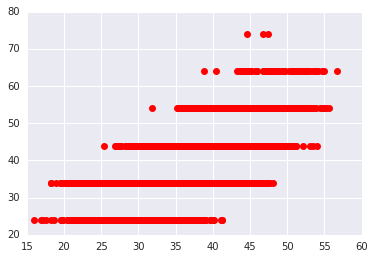

In [279]:
plt.plot(pred_X_titles, y_pred, 'ro')

по логрегу на урлах

In [344]:
y_new = map(lambda x: (x+2)//10, y)

In [345]:
%%title
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

labels = OneVsRestClassifier(LogisticRegression(random_state=0)).fit(X_nmf_urls2[itrain, :], np.array(y_new)[itrain]).predict(X_nmf_urls2[itest, :])

In [340]:
labels

array([3, 4, 3, ..., 3, 3, 3])

In [341]:
np.array(y_new)[itest]

array([5, 3, 2, ..., 3, 3, 4])

In [342]:
for i in range(0,9):
    y_pred = map(lambda x: x*10 + i, labels)
    print i, rmse(y[itest], y_pred)

0 13.1444512299
1 12.8306991112
2 12.5887680583
3 12.422854856
4 12.3360270881
5 12.3299556311
6 12.404759063
7 12.5589923543
8 12.7897822695


In [343]:
y_pred = map(lambda x: x*10 + 4, labels)
print rmse(y[itest], y_pred)

12.3360270881


linreg on data_titles

In [107]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_titles[itrain, :], y[itrain])

pred_X_titles = reg.predict(X_titles[itest, :])

CPU times: user 3min 34s, sys: 4min 28s, total: 8min 3s
Wall time: 48.2 s


In [108]:
print rmse(y[itest], pred_X_titles)

11.9066266739


Линейная модель на NMF_100 от titles

In [109]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_nmf_title1[itrain, :], y[itrain])

pred_X_nmf_title1 = reg.predict(X_nmf_title1[itest, :])

CPU times: user 8.41 s, sys: 5.36 s, total: 13.8 s
Wall time: 1.01 s


In [110]:
print rmse(y[itest], pred_X_nmf_title1)

11.9731456527


Линейная модель на NMF_200 от titles

In [111]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_nmf_title2[itrain, :], y[itrain])

pred_X_nmf_title2 = reg.predict(X_nmf_title2[itest, :])

CPU times: user 12 s, sys: 15 s, total: 27 s
Wall time: 1.93 s


In [112]:
print rmse(y[itest], pred_X_nmf_title2)

11.9276659258


linreg on data_urls

In [163]:
X_urls_m.shape

(118679, 1010)

In [162]:
X_urls_m = np.hstack([X_urls, normed_probs[normed_probs.columns[1:-1]]])

In [165]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_urls_m[itrain, :], y[itrain])

pred_X_urls_m = reg.predict(X_urls_m[itest, :])

CPU times: user 1min 2s, sys: 2min 16s, total: 3min 19s
Wall time: 21.5 s


In [166]:
print rmse(y[itest], pred_X_urls_m)

11.8821947638


Линейная модель на NMF_100 от urls

In [167]:
X_nmf_urls1_m = np.hstack([X_nmf_urls1, normed_probs[normed_probs.columns[1:-1]]])

In [168]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_nmf_urls1_m[itrain, :], y[itrain])

pred_X_nmf_urls1 = reg.predict(X_nmf_urls1_m[itest, :])
print rmse(y[itest], pred_X_nmf_urls1)

11.9395690478
CPU times: user 12.8 s, sys: 10.3 s, total: 23.1 s
Wall time: 1.91 s


Линейная модель на NMF_200 от urls

In [116]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_nmf_urls2[itrain, :], y[itrain])

pred_X_nmf_urls2 = reg.predict(X_nmf_urls2[itest, :])
print rmse(y[itest], pred_X_nmf_urls2)

11.8932235612
CPU times: user 12 s, sys: 17.4 s, total: 29.4 s
Wall time: 2.09 s


linreg on all data

In [117]:
%%time

X = np.hstack([X_urls, X_titles, X_nmf_title1, X_nmf_urls1, X_nmf_title2, X_nmf_urls2])
reg = LinearRegression(n_jobs=-1)
reg.fit(X[itrain, :], y[itrain])

CPU times: user 13min 37s, sys: 9min 54s, total: 23min 31s
Wall time: 2min 32s


In [118]:
pred_X = reg.predict(X[itest, :])
print rmse(y[itest], pred_X)

11.8463762633


scatters

In [169]:
import matplotlib.pyplot as plt
%matplotlib inline

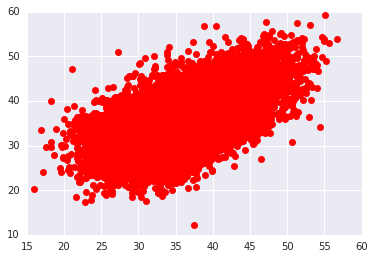

In [171]:
plt.plot(pred_X_titles, pred_X_urls, 'ro')

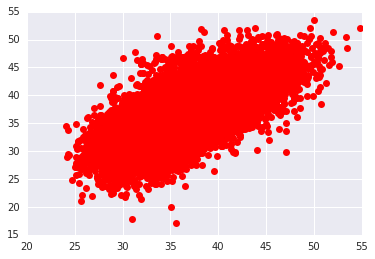

In [172]:
plt.plot(pred_X_nmf_title1, pred_X_nmf_urls1, 'ro')

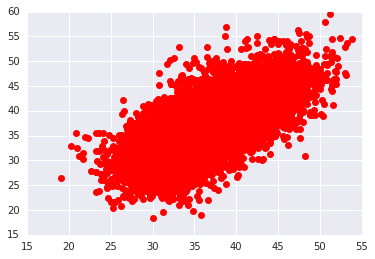

In [173]:
plt.plot(pred_X_nmf_title2, pred_X_nmf_urls2, 'ro')

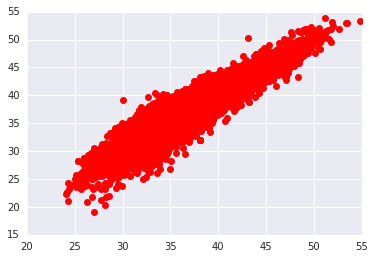

In [176]:
plt.plot(pred_X_nmf_title1, pred_X_nmf_title2, 'ro')

11.7337790362


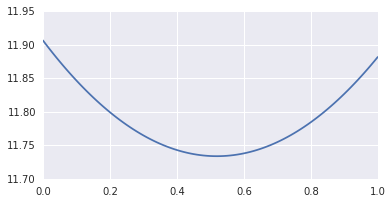

In [119]:
error = []
for w in np.linspace(0, 1, 101):
     error += [rmse(y[itest], pred_X_urls * w + (1-w) * pred_X_titles)]

pd.Series(error, index=np.linspace(0, 1, 101)).plot(figsize=(6,3))
print min(error)

combination on all

In [77]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_urls, y)

pred_X_urls_all = reg.predict(X_urls_test)

CPU times: user 1min 29s, sys: 2min 15s, total: 3min 45s
Wall time: 20.9 s


In [78]:
%%time
reg = LinearRegression(n_jobs=-1)
reg.fit(X_titles, y)

pred_X_titles_all = reg.predict(X_titles_test)

CPU times: user 4min 57s, sys: 5min 11s, total: 10min 8s
Wall time: 1min 7s


In [79]:
X_urls.shape, X_titles.shape

((118679, 1000), (118679, 2000))

In [80]:
pred_X_urls_all[:10]

array([ 39.71610381,  41.56605595,  41.54794928,  32.61228843,
        39.07584376,  38.2834281 ,  42.48696747,  36.08954451,
        42.25106242,  44.18173812])

In [81]:
pred_X_titles_all[:10]

array([ 37.57136639,  41.88855385,  33.87670624,  34.1181525 ,
        35.53460644,  35.13393273,  45.25657435,  37.4247949 ,
        44.15919005,  44.03959092])

In [82]:
res_pred = 0.5*pred_X_urls_all + 0.5*pred_X_titles_all

In [83]:
res_pred[:10]

array([ 38.6437351 ,  41.7273049 ,  37.71232776,  33.36522047,
        37.3052251 ,  36.70868041,  43.87177091,  36.75716971,
        43.20512623,  44.11066452])

## Blenging с помощью heamy
pip install heamy

https://github.com/rushter/heamy

In [138]:
from sklearn import pipeline, preprocessing, feature_extraction

In [216]:
#%%time

dataset_titles = Dataset(X_titles[itrain, :], y[itrain], X_titles[itest, :])
dataset_urls = Dataset(X_urls[itrain, :], y[itrain], X_urls[itest, :]) 

dataset_titles_nmf = Dataset(X_nmf_title1[itrain, :], y[itrain], X_nmf_title1[itest, :])
dataset_urls_nmf = Dataset(X_nmf_urls1[itrain, :], y[itrain], X_nmf_urls1[itest, :])

dataset_titles_nmf2 = Dataset(X_nmf_title2[itrain, :], y[itrain], X_nmf_title2[itest, :])
dataset_urls_nmf2 = Dataset(X_nmf_urls2[itrain, :], y[itrain], X_nmf_urls2[itest, :])

# линейная модель на обычных данных
lr1 = Regressor(dataset=dataset_urls, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr1')

# линейная модель на TFIDF от обычных данных
def tfidf_lr_(X_train, y_train, X_test, y_test=None, random_state=8888):
    model = pipeline.Pipeline([('tfidf', feature_extraction.text.TfidfTransformer()), 
                                ('linear_model', linear_model.LinearRegression())])
    model.fit(X_train, y_train)
    return model.predict(X_test)

tfidf_lr1 = Regressor(dataset=dataset_urls,
                     estimator=tfidf_lr_,
                     name='tfidf_lr1')

lr2 = Regressor(dataset=dataset_titles, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr2')


lr3 = Regressor(dataset=dataset_titles_nmf, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr3')

lr4 = Regressor(dataset=dataset_urls_nmf, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr4')

lr5 = Regressor(dataset=dataset_titles_nmf2, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr5')

lr6 = Regressor(dataset=dataset_urls_nmf2, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr6')



tfidf_lr2 = Regressor(dataset=dataset_titles,
                     estimator=tfidf_lr_,
                     name='tfidf_lr2')

"""xgb_regr2 = Regressor(dataset=dataset_titles, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 1500, 'max_depth':5, 'learning_rate': 0.03,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7},
                     name='xgb_regr2')"""

# ExtraTrees на NMF
xgb_regr1 = Regressor(dataset=dataset_urls_nmf, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr1')

xgb_regr2 = Regressor(dataset=dataset_titles_nmf, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr2')

xgb_regr3 = Regressor(dataset=dataset_urls_nmf2, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr3')

xgb_regr4 = Regressor(dataset=dataset_titles_nmf2, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr4')



rf1 = Regressor(dataset=dataset_urls_nmf, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1, 'max_depth': None, 'bootstrap': True},
                     name='rf1')

rf2 = Regressor(dataset=dataset_titles_nmf, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1, 'max_depth': None, 'bootstrap': True},
                     name='rf2')


rf3 = Regressor(dataset=dataset_urls_nmf2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 200, 'n_jobs': -1, 'max_depth': None, 'bootstrap': True},
                     name='rf3')

rf4 = Regressor(dataset=dataset_titles_nmf2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 200, 'n_jobs': -1, 'max_depth': None, 'bootstrap': True},
                     name='rf4')

# Stack four models
# Returns new dataset with out-of-fold predictions
meta_pipeline = ModelsPipeline(lr1, lr2, lr3, lr4, lr5, lr6, tfidf_lr1, tfidf_lr2, rf1, rf2, rf3, rf4, xgb_regr1, xgb_regr2, xgb_regr3, xgb_regr4)
stack_ds = meta_pipeline.blend(proportion=0.2,seed=111)

# Train LinearRegression on stacked data (second stage)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.predict()

In [217]:
print('ok')

ok


In [218]:
print rmse(y[itest], results)

11.6098376789


tune et clf

In [195]:
%%time
from sklearn.ensemble import ExtraTreesRegressor
et = ExtraTreesRegressor(n_estimators=200, max_depth=None, min_samples_split=1, min_samples_leaf=3, 
                         min_weight_fraction_leaf=0.0,
                         bootstrap=True, oob_score=True, n_jobs=-1, 
                         random_state=42, verbose=1, warm_start=True)


et.fit(X_nmf_title2[itrain, :], y[itrain])
print rmse(y[itest], et.predict(X_nmf_title2[itest, :]))

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.0min finished
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.4s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.6s finished


11.8946575865
CPU times: user 1h 33min 57s, sys: 2.05 s, total: 1h 33min 59s
Wall time: 4min 14s


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.4s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.5s finished


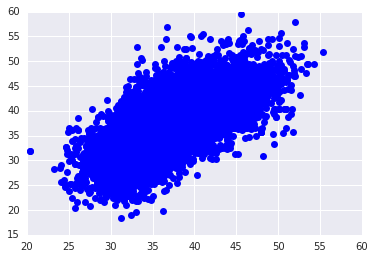

In [200]:
plt.plot(et.predict(X_nmf_title2[itest, :]), pred_X_nmf_urls2, 'bo')

xgb parameter tuning

In [213]:
param = {}
param['max_depth'] = 3
param['booster'] = 'gbtree'
param['objective'] = 'reg:linear'
param['eval_metric'] = 'rmse'
param['eta'] = 0.01
param['subsample'] = 0.6
param['colsample_bytree'] = 0.9
param['colsample_bylevel'] = 0.7
#param['min_child_weight'] = 1
param['gamma'] = 0.1
#param['reg_alpha'] = 1e-05
#param['scale_pos_weight'] = 1

numround = 1000

In [214]:
X_all_datatrain = xgb.DMatrix(X_nmf_urls2, label = y)

In [215]:
xgb.cv(param, X_all_datatrain, num_boost_round=5000, nfold=3, metrics="rmse", \
       verbose_eval=10, as_pandas=False, seed=27)

[0]	train-rmse:37.3679+0.0242207	test-rmse:37.3679+0.0492523
[10]	train-rmse:34.1916+0.0228641	test-rmse:34.1921+0.0492532
[20]	train-rmse:31.3558+0.0206975	test-rmse:31.3569+0.0504866
[30]	train-rmse:28.8258+0.0188912	test-rmse:28.8277+0.0515205
[40]	train-rmse:26.5781+0.0174202	test-rmse:26.5807+0.0521531
[50]	train-rmse:24.5859+0.017571	test-rmse:24.5895+0.0513408
[60]	train-rmse:22.8263+0.0173039	test-rmse:22.8306+0.0509461
[70]	train-rmse:21.278+0.0165585	test-rmse:21.2834+0.0510797
[80]	train-rmse:19.9204+0.0167031	test-rmse:19.9267+0.0507652
[90]	train-rmse:18.7367+0.0166239	test-rmse:18.7444+0.0503545
[100]	train-rmse:17.7094+0.0160764	test-rmse:17.7188+0.0504113
[110]	train-rmse:16.8205+0.0160419	test-rmse:16.8312+0.0497623
[120]	train-rmse:16.0562+0.0160472	test-rmse:16.0682+0.049665
[130]	train-rmse:15.401+0.0159492	test-rmse:15.4144+0.0490901
[140]	train-rmse:14.8423+0.0161323	test-rmse:14.8572+0.0483068
[150]	train-rmse:14.3678+0.0160437	test-rmse:14.384+0.0477125
[160]	tr

KeyboardInterrupt: 

In [189]:
%%time
xgb_regr1 = xgb.XGBRegressor(n_estimators=5000, max_depth=3, learning_rate=0.01, subsample=0.6, 
                             colsample_bytree=0.9, colsample_bylevel = 0.7, gamma=0.1, )
xgb_regr1.fit(X_nmf_title1[itrain, :], y[itrain])

pred_xgb1 = xgb_regr1.predict(X_nmf_title1[itest, :])
print rmse(y[itest], pred_xgb1)

11.8325464979
CPU times: user 1h 3min 33s, sys: 2.38 s, total: 1h 3min 35s
Wall time: 2min 43s


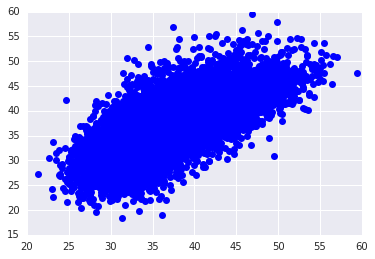

In [190]:
plt.plot(pred_xgb1, pred_X_nmf_urls2, 'bo')

### Обучаем на все

In [219]:
#%%time

dataset_titles = Dataset(X_titles, y, X_titles_test)
dataset_urls = Dataset(X_urls, y, X_urls_test) 

dataset_titles_nmf = Dataset(X_nmf_title1, y, X_nmf_title_test1)
dataset_urls_nmf = Dataset(X_nmf_urls1, y, X_nmf_urls_test1)

dataset_titles_nmf2 = Dataset(X_nmf_title2, y, X_nmf_title_test2)
dataset_urls_nmf2 = Dataset(X_nmf_urls2, y, X_nmf_urls_test2)

# линейная модель на обычных данных
lr1 = Regressor(dataset=dataset_urls, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr1')

# линейная модель на TFIDF от обычных данных
def tfidf_lr_(X_train, y_train, X_test, y_test=None, random_state=8888):
    model = pipeline.Pipeline([('tfidf', feature_extraction.text.TfidfTransformer()), 
                                ('linear_model', linear_model.LinearRegression())])
    model.fit(X_train, y_train)
    return model.predict(X_test)

tfidf_lr1 = Regressor(dataset=dataset_urls,
                     estimator=tfidf_lr_,
                     name='tfidf_lr1')

lr2 = Regressor(dataset=dataset_titles, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr2')


lr3 = Regressor(dataset=dataset_titles_nmf, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr3')

lr4 = Regressor(dataset=dataset_urls_nmf, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr4')

lr5 = Regressor(dataset=dataset_titles_nmf2, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr5')

lr6 = Regressor(dataset=dataset_urls_nmf2, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr6')



tfidf_lr2 = Regressor(dataset=dataset_titles,
                     estimator=tfidf_lr_,
                     name='tfidf_lr2')

"""xgb_regr2 = Regressor(dataset=dataset_titles, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 1500, 'max_depth':5, 'learning_rate': 0.03,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7},
                     name='xgb_regr2')"""

# ExtraTrees на NMF
xgb_regr1 = Regressor(dataset=dataset_urls_nmf, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr1')

xgb_regr2 = Regressor(dataset=dataset_titles_nmf, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr2')

xgb_regr3 = Regressor(dataset=dataset_urls_nmf2, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr3')

xgb_regr4 = Regressor(dataset=dataset_titles_nmf2, 
                     estimator=xgb.XGBRegressor,
                     parameters={'n_estimators': 5000, 'max_depth':3, 'learning_rate': 0.01,
                                'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel':0.7, 'gamma': 0.1},
                     name='xgb_regr4')



rf1 = Regressor(dataset=dataset_urls_nmf, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1, 'max_depth': None, 'bootstrap': True},
                     name='rf1')

rf2 = Regressor(dataset=dataset_titles_nmf, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1, 'max_depth': None, 'bootstrap': True},
                     name='rf2')


rf3 = Regressor(dataset=dataset_urls_nmf2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 200, 'n_jobs': -1, 'max_depth': None, 'bootstrap': True},
                     name='rf3')

rf4 = Regressor(dataset=dataset_titles_nmf2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 200, 'n_jobs': -1, 'max_depth': None, 'bootstrap': True},
                     name='rf4')

# Stack four models
# Returns new dataset with out-of-fold predictions
meta_pipeline = ModelsPipeline(lr1, lr2, lr3, lr4, lr5, lr6, tfidf_lr1, tfidf_lr2, rf1, rf2, rf3, rf4, xgb_regr1, xgb_regr2, xgb_regr3, xgb_regr4)
stack_ds = meta_pipeline.blend(proportion=0.2,seed=111)

# Train LinearRegression on stacked data (second stage)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.predict()

In [228]:
stack_ds.X_test.to_csv("stack_many_test.csv", index=False)

In [229]:
results

array([ 40.2761439 ,  40.02110021,  37.10676274, ...,  37.76762775,
        37.76762775,  38.36590777])

In [221]:
test_df["age"] = results

In [222]:
test_df.head()

,Id,title,urls,age
0,000000014A02348E701552980349FF01,11-й гектар дом коммунизм на набережная недост...,1000bankov 1tv 1tv 1tv 1tv 1tv 1tv 1tv 1tv 4pu...,40.276144
1,000000014A10EA183BF8594A0B2AB201,20-летний выглядеть девушка как королева наташ...,autorambler bilettorg dsol-druzhba family.ramb...,40.021100
2,000000014A4FE5C33A929D4C26943601,медийный портал рамблер,photosight photosight photosight photosight ph...,37.106763
3,000000014B7BB9957784A9BC0AC9F401,бесплатно код онлайн срочно статистика или инн...,base.consultant dogovor-obrazets fd mail.rambl...,37.370988
4,000000014C7749F896D82C2B01E8B801,bank privat автокредитование банковский банком...,assessor assessor audit-it base.garant compsam...,30.618663


In [223]:
all_set = test_df[["Id", "age"]]

In [166]:
all_set = all_set.sort_values(by="Id")

In [224]:
all_set.to_csv("stack_6linreg_title_urls_with_nmf_4rf_4xgb.csv", index=False, encoding='utf-8')

In [211]:
all_set = urls_test_df.merge(miss_df, how='outer')[["Id", "age"]]

In [362]:
all_set.head()

,Id,age
0,000000014A02348E701552980349FF01,40.276144
1,000000014A10EA183BF8594A0B2AB201,40.021100
2,000000014A4FE5C33A929D4C26943601,37.106763
3,000000014B7BB9957784A9BC0AC9F401,37.370988
4,000000014C7749F896D82C2B01E8B801,30.618663


In [213]:
all_set.sort_values(by="Id").to_csv("stacking_with_titles_2lr_tfidfLR_2xgb.csv", index=False)